In [1]:
%matplotlib notebook

import numpy as np
import gensim, logging
import pandas as pnd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, RandomizedPCA
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Topic Model

In [3]:
# Prepare data in long form

df = pnd.read_csv("../code/resources/topics.txt", header=None)
df["topic"] =  df.index
df["topic_name"] = df[0]
df = pnd.melt(df, id_vars=["topic", "topic_name"], var_name="position", value_name="word")
df = df[["word", "topic", "topic_name", "position"]]
df = df.sort_values(by=["topic", "position"]).reset_index(drop=True)
df[df.topic == 0]

,word,topic,topic_name,position
0,english,0,english,0
1,england,0,english,1
2,king,0,english,2
3,one,0,english,3
4,scotland,0,english,4
5,britain,0,english,5
6,british,0,english,6
7,london,0,english,7
8,john,0,english,8
9,name,0,english,9


# Word Embeddings

In [4]:
WORD2VEC_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/GoogleNews-vectors-negative300.bin"
GLOVE_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/glove.6B.50d.txt"
OUR_VECTOR_FILE = "/home/knub/Repositories/master-thesis/data/embedding.model.skipgram"

#word2vec = gensim.models.Word2Vec.load_word2vec_format(GLOVE_VECTOR_FILE, binary=False)
word2vec = gensim.models.Word2Vec.load_word2vec_format(WORD2VEC_VECTOR_FILE, binary=True)

In [5]:
df = df[df["word"].apply(lambda word: word in word2vec)]    
df["embeddings"] = df["word"].apply(lambda word: word2vec[word])
df[df.topic == 0]

,word,topic,topic_name,position,embeddings
0,english,0,english,0,"[-0.139648, -0.292969, 0.0800781, -0.00927734,..."
1,england,0,english,1,"[-0.367188, -0.0349121, 0.11084, 0.400391, 0.1..."
2,king,0,english,2,"[0.125977, 0.0297852, 0.00860596, 0.139648, -0..."
3,one,0,english,3,"[0.0456543, -0.145508, 0.15625, 0.166016, 0.10..."
4,scotland,0,english,4,"[-0.0732422, -0.176758, 0.108398, 0.240234, 0...."
5,britain,0,english,5,"[-0.208984, 0.160156, 0.0380859, 0.566406, -0...."
6,british,0,english,6,"[-0.0888672, 0.024292, 0.074707, 0.359375, -0...."
7,london,0,english,7,"[-0.460938, 0.0279541, -0.267578, 0.410156, -0..."
8,john,0,english,8,"[-0.253906, 0.147461, -0.081543, 0.208984, -0...."
9,name,0,english,9,"[0.148438, 0.152344, 0.0693359, 0.0478516, -0...."


In [6]:
# financial, muslim, teams in sport, atom physics, math
nice_topics = [5, 117, 158, 164, 171]

df_part = df[df.topic.apply(lambda topic: topic in nice_topics)]
# Show topics of interest
df_part.groupby("topic")["word"].apply(lambda l: " ".join(l)).tolist()

['economic economy financial foreign gdp government bank oil trade countries',
 'islamic muslim islam population arab ibn muslims muhammad afghanistan arabic',
 'team league season first game new football nfl record teams',
 'electrons particles electron energy charge electric units current particle one',
 'distribution mean probability sample data random population used two function']

# Dimensionality Reduction

In [22]:
def pca(embeddings):
    pca = RandomizedPCA(n_components=2)
    return pca.fit_transform(embeddings)

def tsne(embeddings):
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(embeddings)

def tsne_with_init_pca(embeddings):
    tsne = TSNE(n_components=2, init="pca")
    return tsne.fit_transform(embeddings)

# Plots

In [15]:
def plot_topics_in_embedding_space(reduction_method, df):
    embeddings = np.array(df["embeddings"].tolist())
    X = reduction_method(embeddings)
    df_tmp = df.copy()
    df_tmp["x"] = X[:,0]
    df_tmp["y"] = X[:,1]
    df_tmp = df_tmp[df_tmp.topic.apply(lambda topic: topic in nice_topics)]
    colors = {5: "red", 117: "blue", 158: "green", 164: "yellow", 171: "black"}
    plt.figure(figsize=(12, 8))
    plt.scatter(df_tmp.x, df_tmp.y, c=df_tmp.topic.apply(lambda topic: colors[topic]), s=80)
    
    ylim = plt.gca().get_ylim()
    step = (ylim[1] - ylim[0]) / 100
    
    for index, row in df_tmp.iterrows():
        plt.text(row.x, row.y - step, row.word, horizontalalignment='center', verticalalignment='top')

## PCA

<IPython.core.display.Javascript object>


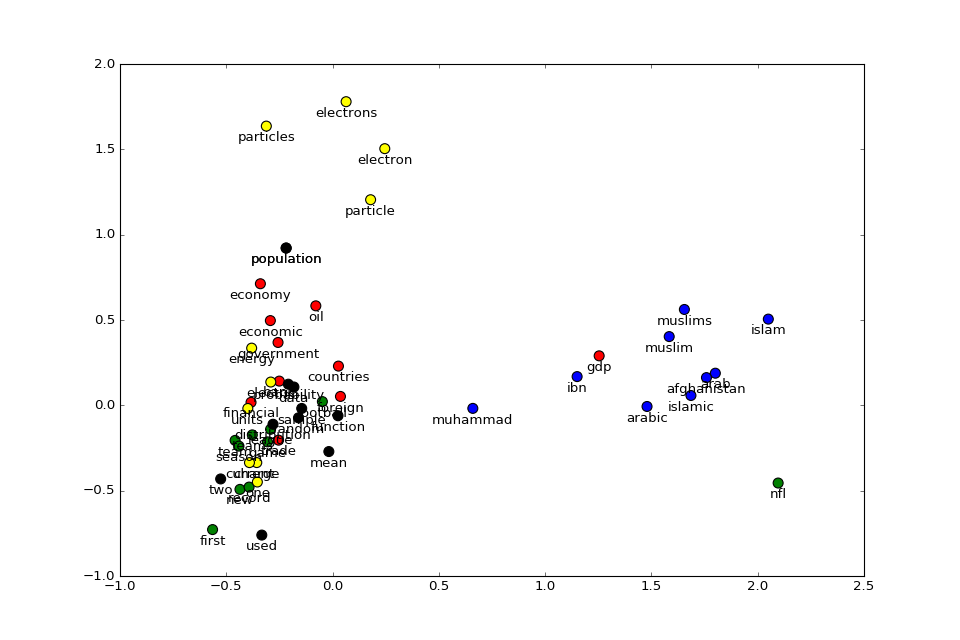

In [27]:
plot_topics_in_embedding_space(pca, df)

<IPython.core.display.Javascript object>


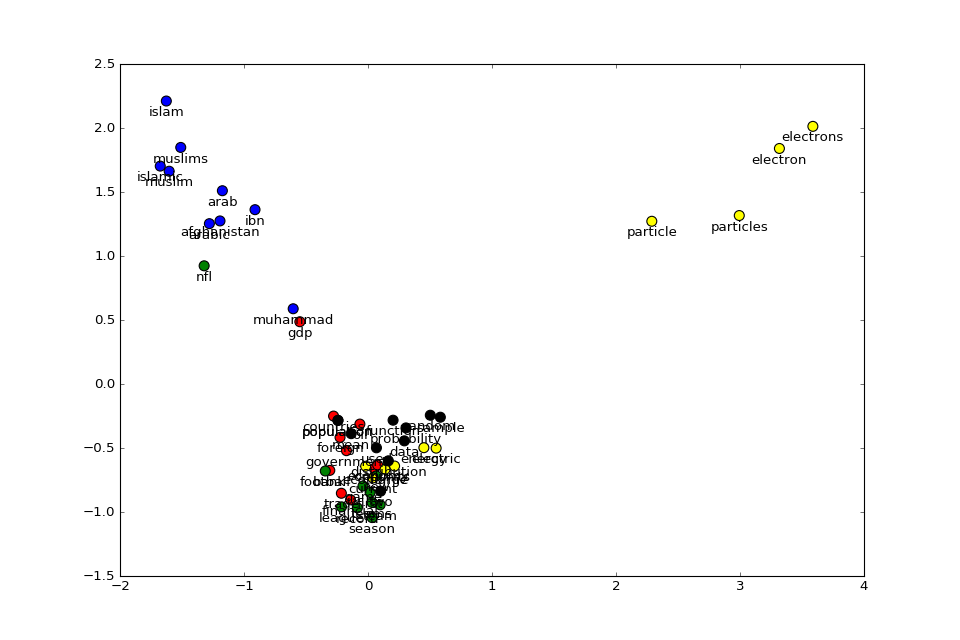

In [28]:
plot_topics_in_embedding_space(pca, df_part)

## TSNE

<IPython.core.display.Javascript object>


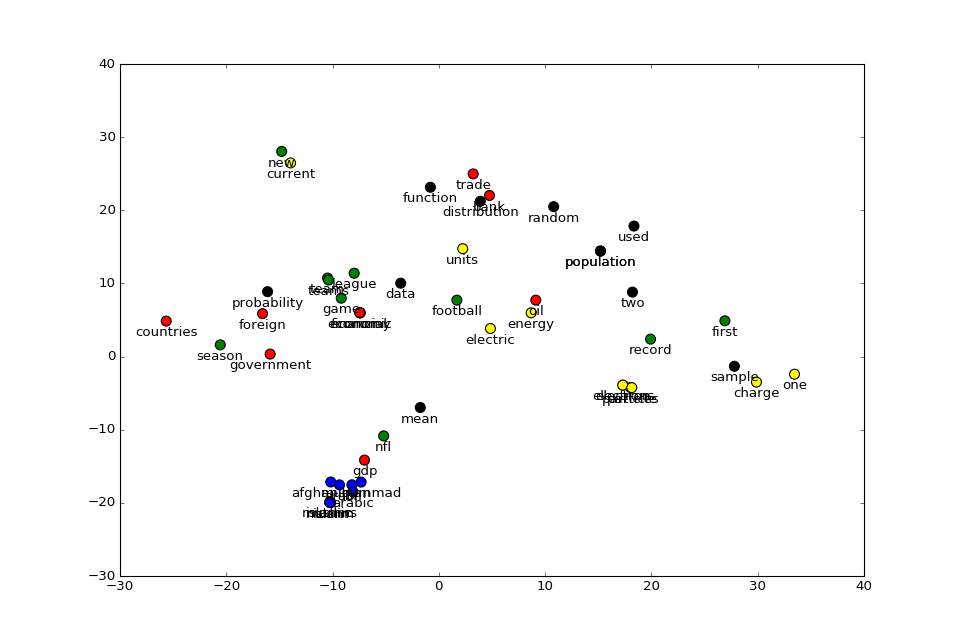

In [23]:
plot_topics_in_embedding_space(tsne, df)

In [26]:
#plot_topics_in_embedding_space(tsne, df_part)

## TSNE with PCA initialization

<IPython.core.display.Javascript object>


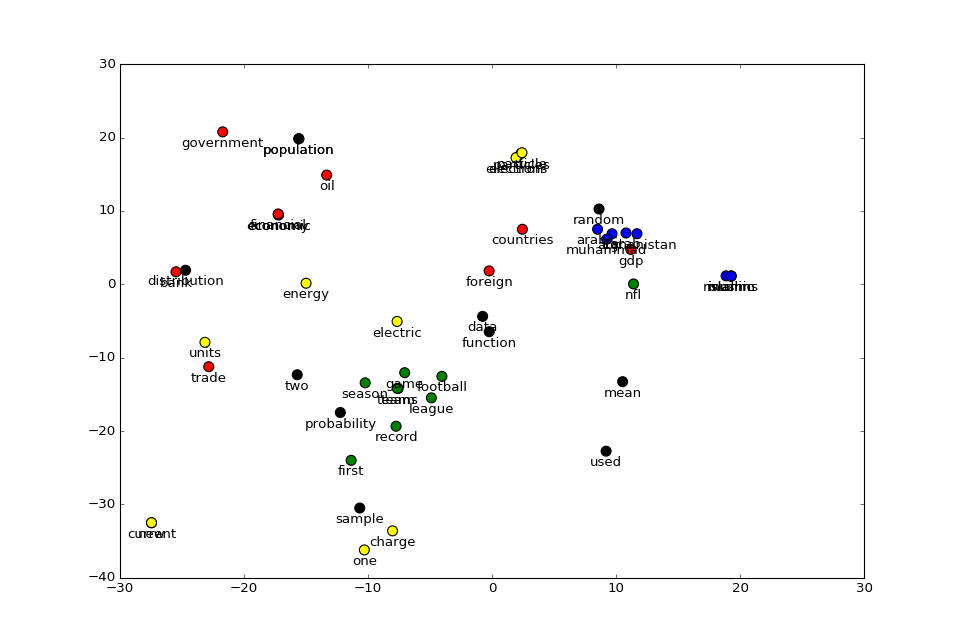

In [25]:
plot_topics_in_embedding_space(tsne_with_init_pca, df)

# Findings
* **Specifity**: The more specific a word is, the closer it is to similar words in the word embedding space
* **Ambiguity**: Ambiguous words are a special problem, for example "current" is far away from the other physic terms because it has too many meanings. In fact, it is very close to the word "new".
* **Context-based similarity**: Topic models can assign different similarities between words based on the context. They are good at finding similar words in a context, which might not be immediately obvious. Example: "distribution" is not very similar to "function", however in the company of "mean", "probability", "data", "random" it is.